In [3]:
import os
from turtle import title
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from fears.utils import results_manager, dir_manager, stats, plotter
import pandas as pd
import pickle

os.chdir('/Users/eshanking/repos/seascapes_figures')

exp_info_path = 'results/results_09292023_0001/experiment_info_09292023_0001.p'
xmin = 4*24
xmax = 500

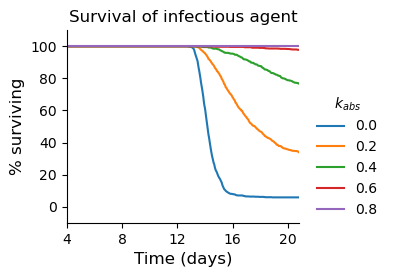

In [4]:
resistance_outcome = [1,2]

roc_exp = pickle.load(open(exp_info_path,'rb'))

data_folder = roc_exp.results_path
exp_info_file = roc_exp.experiment_info_path

exp_folders,exp_info = results_manager.get_experiment_results(exp=roc_exp)

n_sims = exp_info.n_sims
p_drop = exp_info.prob_drops

# fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(8,2.5))
fig,ax = plt.subplots(figsize=(3,2.5))

pop = exp_info.populations[0]

xticks = np.arange(0,pop.n_timestep,96)

km_data = stats.km_curve(exp=roc_exp,resistance_outcome=resistance_outcome)
prop_data1 = stats.n_mut_curve(exp=roc_exp,nmut=1)
prop_data2 = stats.n_mut_curve(exp=roc_exp,nmut=2)
prop_data3 = stats.n_mut_curve(exp=roc_exp,nmut=3)
prop_data4 = stats.n_mut_curve(exp=roc_exp,nmut=4)

max_idx_dict = stats.most_freq_genotype(exp=roc_exp,mode=None)

tmax = int(pop.n_timestep)

for p_drop in km_data.keys():
    
    exp_dict = km_data[p_drop]

    death_event_times = exp_dict['survival']

    ax = plotter.plot_kaplan_meier(pop,death_event_times,
                                        ax=ax,
                                        n_sims=n_sims,
                                        label=p_drop,
                                        mode='survival',
                                        t_max=tmax)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

pad = 0.05

ax.set_ylabel('% surviving',fontsize=12)
ax.set_xlabel('Time (days)',fontsize=12)

ax.set_title('Survival of infectious agent',fontsize=12)

ax.set_ylim([-10,110])

ax.set_xticks(xticks)

ax = plotter.x_ticks_to_days(pop,ax)

ax.set_xlim([xmin,xmax])

ax.legend(frameon=False,fontsize=10,loc=(1.05,0),title='$k_{abs}$')

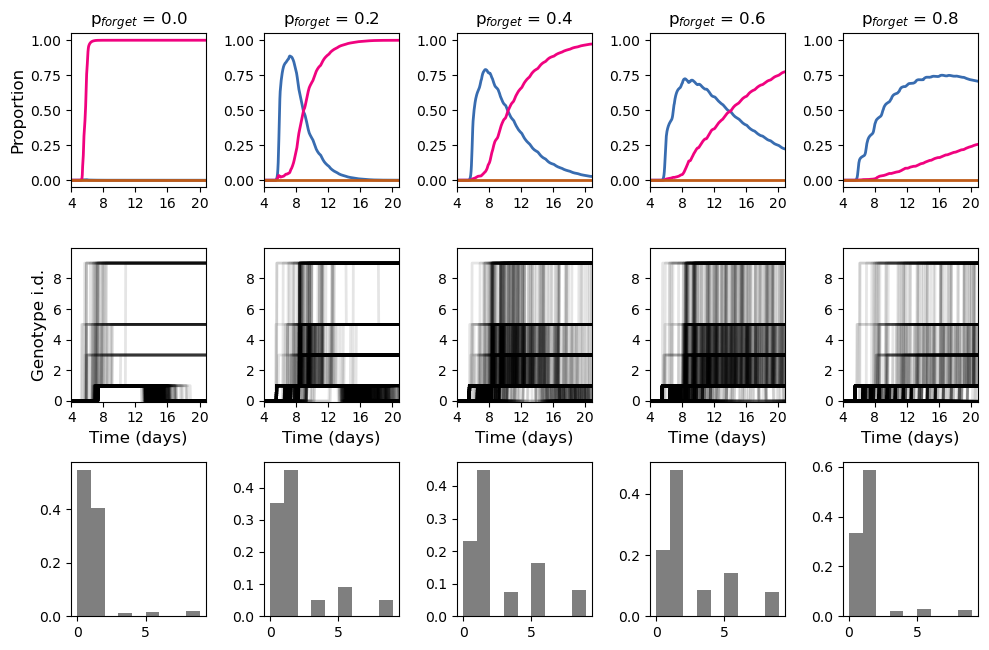

In [5]:
n_conditions = len(km_data.keys())
fig,ax_list = plt.subplots(nrows=3,ncols=n_conditions,figsize=(2*n_conditions,6.6),
                            sharex=False,sharey=False)

cmap = plt.get_cmap('Accent')

indx = 0
for key in prop_data1.keys():
    ax = ax_list[0,indx]

    ax.plot(prop_data1[key],label='1',linewidth=2,color=cmap(4))
    ax.plot(prop_data2[key],label='2',linewidth=2,color=cmap(5))
    ax.plot(prop_data3[key],label='3',linewidth=2,color=cmap(6))

    ax.set_ylim([-0.05,1.05])

    # ax.set_yscale('symlog',linthresh=0.1)

    ax.set_xticks(xticks)

    ax = plotter.x_ticks_to_days(pop,ax)

    ax.set_xlim([xmin,xmax])
    ax.set_title('p$_{forget}$ = ' + key,fontsize=12)

    # ax.legend(frameon=False,title='$n_{mut}$',fontsize=10)
    
    ax = ax_list[1,indx]

    max_idx = max_idx_dict[key]

    for i in range(max_idx.shape[1]):
        ax.plot(max_idx[:,i],linewidth=2,color='k',alpha=0.1)

    ax.set_yticks(np.arange(0,10,2))

    ax.set_ylim([-0.05,10])

    ax.set_xlabel('Time (days)',fontsize=12)

    ax = ax_list[2,indx]

    max_idx = max_idx[xmin:xmax,:]

    max_idx = max_idx.flatten()

    ax.hist(max_idx,bins=np.arange(0,10,1),color='k',alpha=0.5,density=True)

    indx+=1

for ax in ax_list[0:2,:].flatten():
    ax.set_xticks(xticks)

    ax = plotter.x_ticks_to_days(pop,ax)

    ax.set_xlim([xmin,xmax])

ax_list[0,0].set_ylabel('Proportion',fontsize=12)
ax_list[1,0].set_ylabel('Genotype i.d.',fontsize=12)
fig.tight_layout()

Text(0, 0.5, 'Drug concentration (ug/mL)')

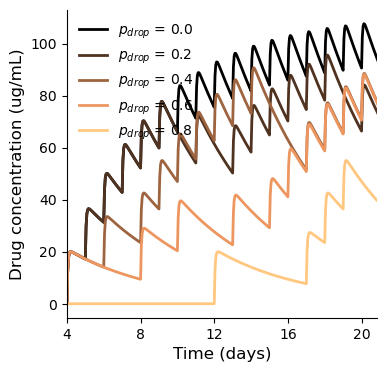

In [6]:
fig,ax = plt.subplots(figsize=(4,4))

cmap = plt.cm.get_cmap('copper')

xticks = np.arange(0,pop.n_timestep,96)

indx = 0
for p in exp_info.populations:
    ax.plot(p.drug_curve,color=cmap(indx/(n_conditions-1)),linewidth=2,label='$p_{drop}$ = ' + str(p.prob_drop))
    
    ax.set_xticks(xticks)

    ax = plotter.x_ticks_to_days(p,ax)
    ax.set_xlim([xmin,xmax])
    indx+=1

ax.legend(frameon=False,fontsize=10)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlabel('Time (days)',fontsize=12)
ax.set_ylabel('Drug concentration (ug/mL)',fontsize=12)

In [7]:
def compute_doses(regimen,pop):

    dose_schedule = pop.dose_schedule/pop.timestep_scale
    n_doses = int(np.floor(pop.n_timestep/dose_schedule))

    doses = np.zeros(n_doses)

    dose_num = 0

    for i in range(n_doses):
        if regimen[int(i*dose_schedule)] == 1:
            doses[dose_num] = 1
        dose_num += 1
    
    return doses

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_15849/3037307106.py:83: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(extinct_hist,survived_hist)


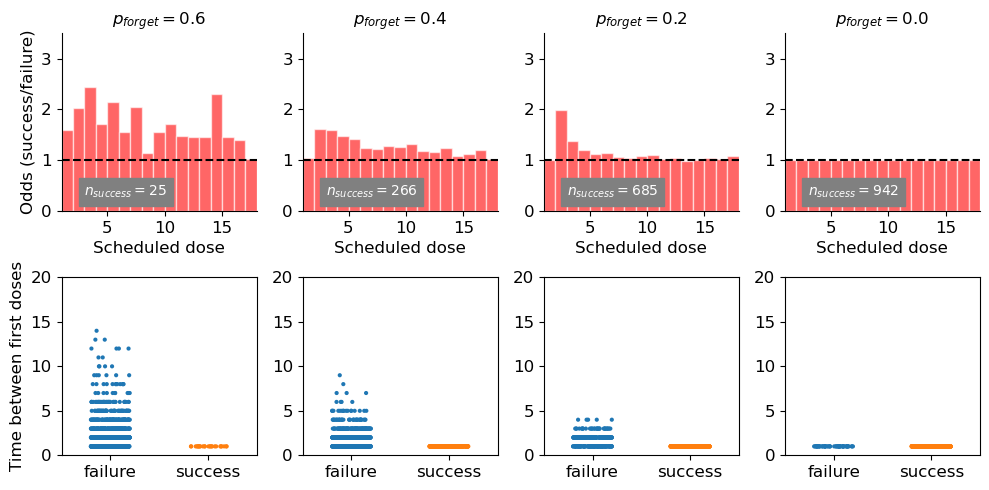

In [8]:
def conf_interval(n1,x1,n2,x2):
    """95% confidence interval for risk ratio

    Args:
        n1 (int): number of trials in group 1
        x1 (int): number of successes in group 1
        n2 (int): number of trials in group 2
        x2 (int): number of successes in group 2

    Returns:
        float: 95% confidence interval
    """
    return 1.96*np.sqrt((n1-x1)/(n1*x1) + (n2-x2)/(n2*x2))

gap = int(pop.dose_schedule/pop.timestep_scale)     
if pop.dwell:
    dwell_doses = int(np.floor(pop.dwell_time/gap))
else:
    dwell_doses = 0

n_scheduled_doses = int(np.floor(pop.n_timestep/gap))-dwell_doses

max_doses = int(np.sum(pop.impulses))

n_subplots = len(exp_folders)-1
fig,ax_list = plt.subplots(ncols=n_subplots,nrows=2,figsize=(10,5))

exp_folders_t = np.flip(exp_folders[:-1])
exp_folders_t = list(exp_folders_t)
exp_folders_t = [str(x) for x in exp_folders_t]
p_drop = exp_info.prob_drops
num = 0

for exp in exp_folders_t:

    ax = ax_list[0,num]
    extinct_sched = np.zeros(n_scheduled_doses)
    extinct_sched = np.array([extinct_sched])
    survived_sched = np.zeros(n_scheduled_doses)
    survived_sched = np.array([survived_sched])
    sim_files = os.listdir(path=exp)
    sim_files = sorted(sim_files)

    p_drop_t = exp[exp.find('=')+1:]
    p_drop_t = p_drop_t.replace(',','.')
    p_drop_t = float(p_drop_t)
    
    # num = np.argwhere(p_drop == p_drop_t)
    # num = num[0,0]
    k=0
    while k < len(sim_files):

        sim = sim_files[k]
        sim = exp + os.sep + sim
        data_dict = results_manager.get_data(sim)
        counts = data_dict['counts']
        counts = np.sum(counts,axis=1)
        # dc = data_dict['drug_curve']
        regimen = data_dict['regimen']
        dose_schedule = compute_doses(regimen,pop)
        dose_schedule = dose_schedule[dwell_doses:]
        dose_schedule = np.array([dose_schedule])
        # dose_schedule = dose_schedule[dwell_doses:]

        if counts[-1]<1:
            extinct_sched = np.concatenate((extinct_sched,dose_schedule),axis=0)
        else:
            survived_sched = np.concatenate((survived_sched,dose_schedule),axis=0)
        k+=1

    extinct_sched = extinct_sched[1:,:]
    survived_sched = survived_sched[1:,:]

    # fig,ax = plt.subplots(2,1,figsize=(6.25,7.75),sharex=True)
    # fig,ax = plt.subplots(figsize=(4,3))
    cmap = mpl.colors.ListedColormap(['cornflowerblue','w'])

    # aspect = n_scheduled_doses/n_sims
    # aspect_surv = n_scheduled_doses/survived_sched.shape[0]

    # ax[0].imshow(extinct_sched,cmap=cmap)
    # ax[1].imshow(survived_sched,cmap=cmap)

    n_extinct = extinct_sched.shape[0]
    n_survived = survived_sched.shape[0]

    survived_hist = np.sum(survived_sched,axis=0)
    sh_counts = survived_hist
    survived_hist = survived_hist/n_survived
    extinct_hist = np.sum(extinct_sched,axis=0)
    ext_counts = extinct_hist
    extinct_hist = extinct_hist/n_extinct

    dose_num = np.arange(len(survived_hist)) + 1
    # p = (1-float(p_drop_t))*np.ones(len(dose_num))

    conf_int = np.zeros(len(survived_hist))
    for i in range(len(survived_hist)):
        conf_int[i] = conf_interval(n_survived,survived_hist[i]*n_survived,
                                    n_extinct,extinct_hist[i]*n_extinct)

    ratio = np.divide(extinct_hist,survived_hist)

    ax.bar(dose_num,ratio,width=1,color='red',alpha=0.6,edgecolor='w',
        align='edge')
    ax.plot(dose_num,np.ones(len(dose_num)),'--',color='black')

    ax.errorbar(dose_num,ratio,yerr=conf_int*2,fmt='none',ecolor='k',capsize=3)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    
    ax.set_xlabel('Scheduled dose',fontsize=12)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    ax.set_xlim(1,max_doses+1)
    ax.set_ylim(0,3.5)

    ax.set_title('$p_{forget} = $' + str(p_drop_t))

    ax.text(x=3,y=0.3,s='$n_{success} = $' + str(n_extinct),
            backgroundcolor='gray',color='w')

    ax = ax_list[1,num]

    time_between_surv = []
    time_between_ext = []

    for s in survived_sched:
        # print(s)
        doses = np.argwhere(s==1)
        if len(doses) > 1:
            time_between_surv.append((doses[1]-doses[0])[0])
    for e in extinct_sched:
        doses = np.argwhere(e==1)
        if len(doses) > 1:
            time_between_ext.append((doses[1]-doses[0])[0])

    d = {'survived':time_between_surv,
            'extinct':time_between_ext}

    # df = pd.DataFrame(d)

    sns.stripplot(ax=ax,data=[time_between_surv,time_between_ext],size=3,
                    jitter=0.2)
    
    # ax.tight_layout()
    ax.set_xticklabels(['failure','success'])

    ax.set_yticks([0,5,10,15,20])
    ax.set_ylim(0,20)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # ax.set_ylabel('Time between first doses',fontsize=12)

    num+=1

ax_list[0,0].set_ylabel('Odds (success/failure)',fontsize=12)
ax_list[1,0].set_ylabel('Time between first doses',fontsize=12)
# fig2.tight_layout()
fig.tight_layout()